# Gliding Assay Analysis
updated 2023-08-13
In this pipeline, we work to determine the speeds of gliding microtubules. We take a series of images of microtubules gliding on top of fixed motor proteins. We segment and extract the positions of microtubules and calculate their speeds.

Import necessary packages to run the notebook

In [1]:
#Numpy - for scientific computing
import numpy as np
import scipy

#For image reading and analysis
import glob
import skimage.io
import skimage.filters as sf
from skimage import io, measure, filters, transform, morphology

#Matplotlib plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt


# For loading bars
from tqdm.notebook import tqdm as tqdm

# For creating DataFrames
import pandas as pd

Import images into the notebook - convert names of files to images

In [5]:
#Import Stack
file_path = '../../data/gliding/'
file_folder = '2023-08-11_Gliding/2023-08-11_Gliding_0.0625uMNCD_50MT_1410uMATP_0uMADP_0uMP_15min_1/images/'
included_frames = '*.tif'
im_dir = file_path+file_folder+included_frames

#Import Stack
im_stack = []
files = np.sort(glob.glob(im_dir))
for file in files:
    im_stack.append(skimage.io.imread(file).astype(np.int16))
im_stack = np.array(im_stack)

#frames = np.arange(len(im_stack))

In [6]:
# Make a maximum projection from a subset of frames from im_stack
#Lets pick 50 frames
start=0
stop=50
acqu_interval = 1 #s acquisition intervals

data_mot = 0.0625 #uM
data_MT = 50 #dilution factor
data_ATP = 1410 #uM
data_ADP = 0 #uM
data_P = 0 #uM
data_time = 15*60 + start*acqu_interval #seconds

umperpixel=0.161

Look at an image in the stack to see what the data looks like

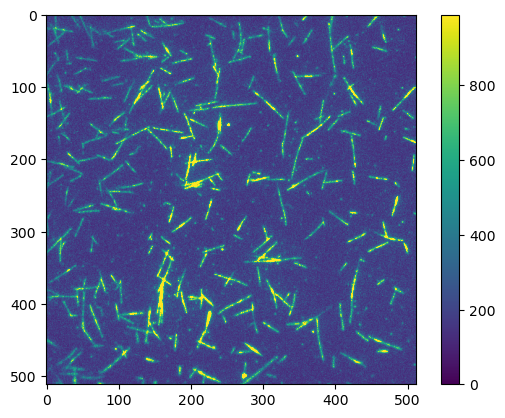

In [7]:
plt.imshow(im_stack[0], vmin= 0, vmax=np.percentile(im_stack[0], 99))
plt.colorbar()

We will now create a maximum projection image. This will look throughout the stack of images and for each pixel, save the greatest intensity value in the stack. We will then have one 2D image.

This is helpful because it helps us identify the tracks microtubules sweep out.

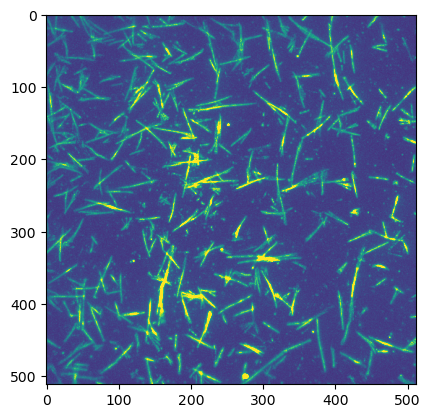

In [8]:
#make max proj
im_max = np.amax(im_stack[start:stop], axis=0)

#plot
plt.imshow(im_max, vmin=0, vmax=np.percentile(im_max, 99))

Apply the next cell if one frame has something far too bright to see anything else. Delete the slice

## Image Processing to clean up the maximum projection
Normalize the image

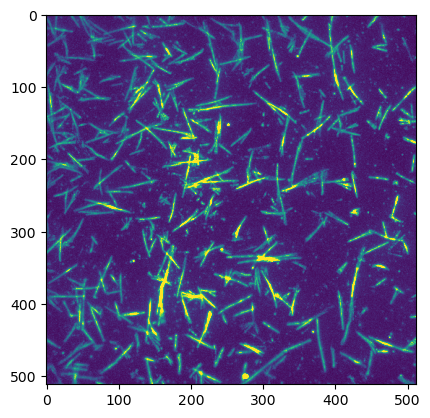

In [9]:
image_norm = (im_max - im_max.min())/(im_max.max()-im_max.min())

#plot the normalized image
plt.imshow(image_norm, vmin=0, vmax=np.percentile(image_norm, 99))

### Thresholding
First method: Niblack thresholding - Looks at small windows throughout the image and separates microtubules from the background. (This method is commonly used to find text especially when the background of an image has uneven illuminatiion)

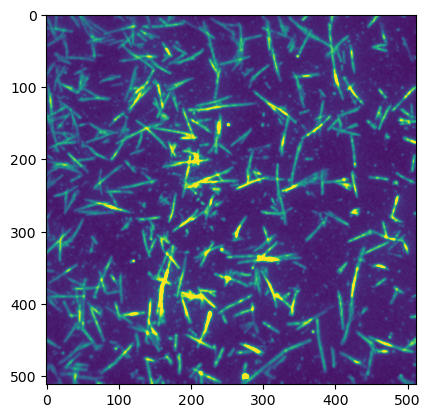

In [10]:
thresh_niblack = filters.threshold_niblack(image_norm, window_size= 3, k=0.001)
plt.imshow(thresh_niblack, vmin=0, vmax=np.percentile(thresh_niblack, 99))

Perform Otsu thresholding - this separates the foreground from the background for the entire image

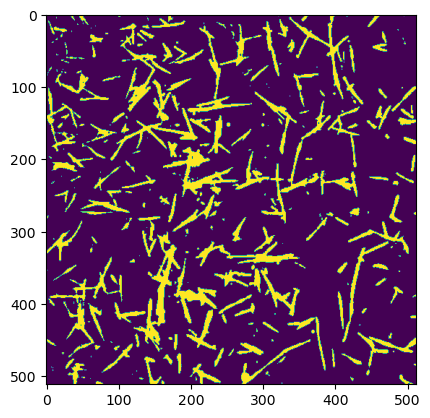

In [11]:
# define the threshold
thresh_otsu = filters.threshold_otsu(thresh_niblack)

#Make a binary image where values above the threshold are = 1 and all else is 0
im_thresh = (thresh_niblack > thresh_otsu)

#Plot
plt.imshow(im_thresh)

### Identify regions of MT tracks

Label each region and assign all pixels within that region a number. Also keep track of the number of pixels in each region

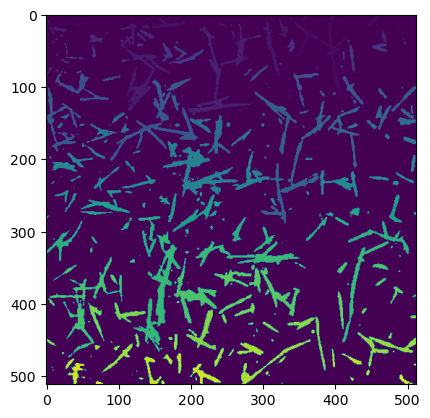

In [12]:
#make a image with each patch labeled a unique number
im_label, n_label = measure.label(im_thresh, return_num=True)

#save the unique labels
unique_regions, region_counts = np.unique(im_label, return_counts = True)

#plot
plt.imshow(im_label)

### Remove non-linear tracks

Remove patches too close to the edges

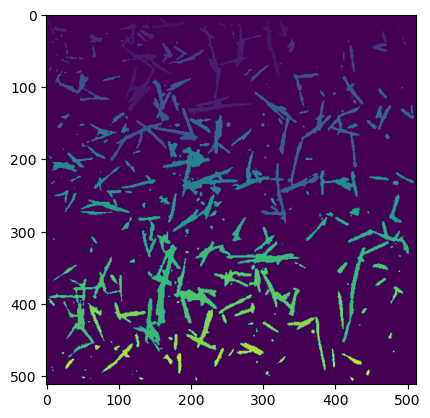

In [13]:
#give some border width
edge = 3

#make an image that will have the border removed
im_border = np.copy(im_label)

#Make the border mask
border = np.ones(np.shape(im_label))
border[edge:-1*edge, edge:-1*edge] -=1

#Ask if there is a nonzero label within the border region and if so remove that patch
for n in np.unique(im_border):
    if np.any(border*[im_border==n+1]):
        im_border[im_border==n+1] = 0

#Save image with border patches eliminated
im_internal = im_border

#plot
plt.imshow(im_internal)

Remove small objects. We set a defined area which each patch must be greater than. Note in this data, 1µm = 6.2 pixels

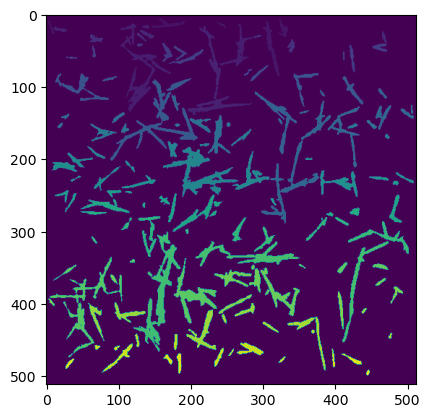

In [14]:
# Define a size threhshold
area_thresh = 20

#Make a dictionary that connects the region label number and the number of pixels within said region
dict_area = dict(zip(unique_regions, region_counts))

#Want to find if each patch is big enough
im_sized = np.copy(im_internal)
for label in unique_regions:
  #ask if region is larger than threshold
  if label>0 and dict_area[label]<=area_thresh:
    im_sized[im_sized==label] = 0

#plot
plt.imshow(im_sized)

Thin each region to create a skeleton while preserving the connectivity of each region.

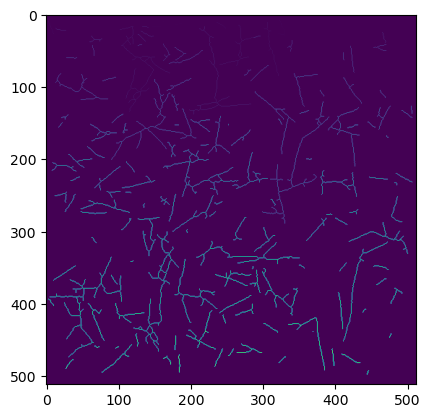

In [15]:
#create skeletons that preserve connectivity
im_thinned = morphology.thin(im_sized)

#Relabel so each skelton has its own label I.D
im_relabel = measure.label(im_thinned)

#plot
plt.imshow(im_relabel)

Use a Hough Transform to identify linear regions. This transform looks at all the lines that could pass through a given point in the labeled region. For each line, the transform measures the length of the normal to the line from the origin and its angle. Performing this process for each point in the labeled region, the transform declares a line to be at the angle where the normal to the line passing through each point has the same length.

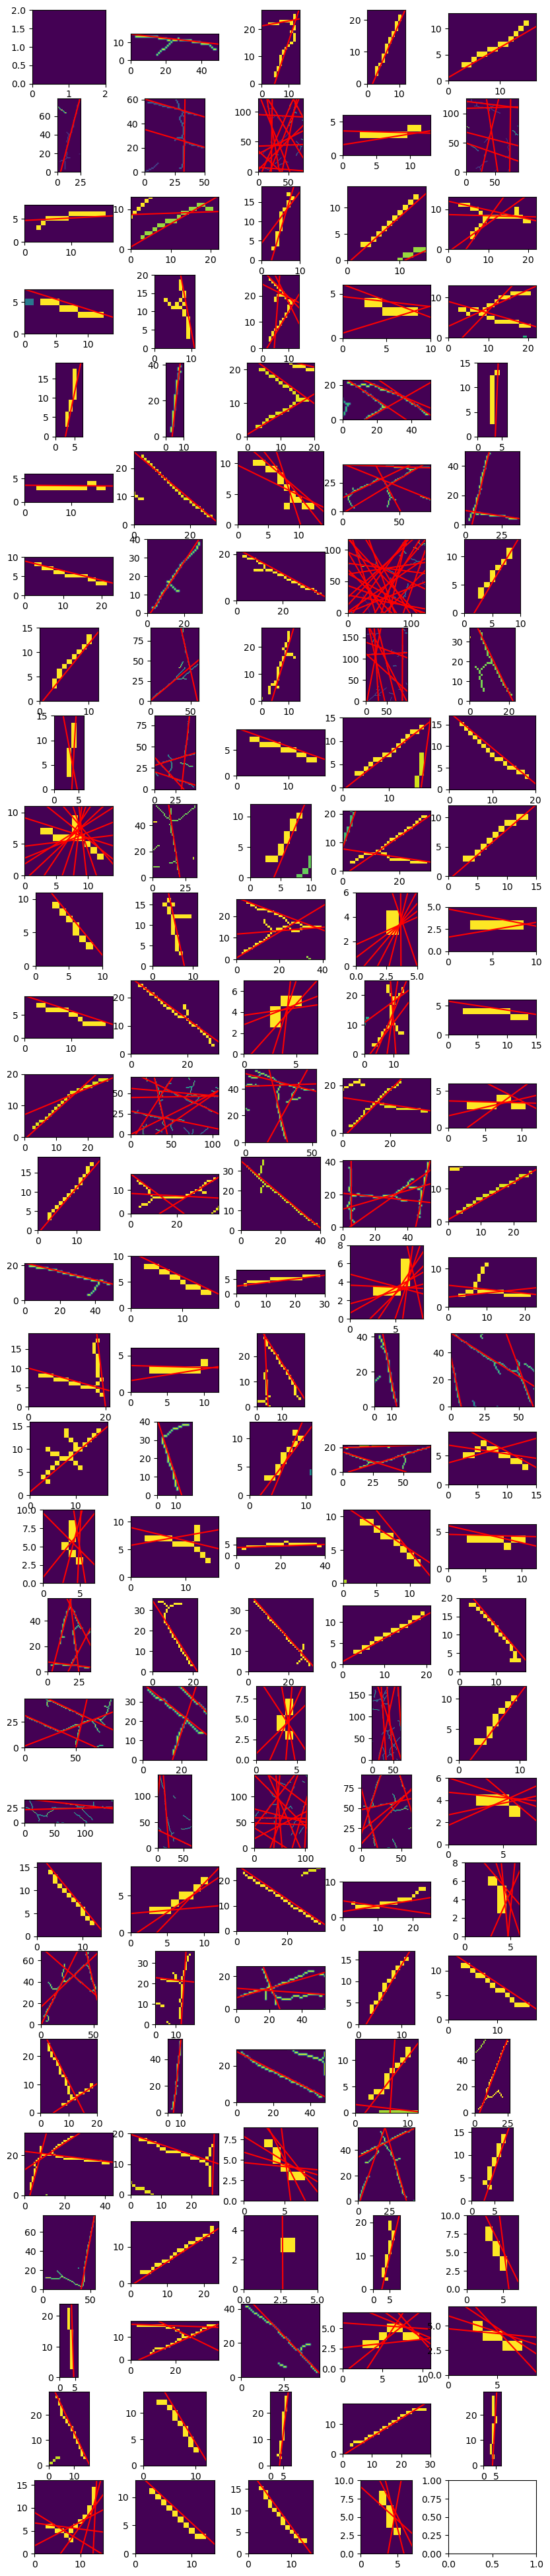

In [16]:
fig, ax = plt.subplots(int(len(np.unique(im_relabel))/5)+1, 5, figsize = (10, 50))
figj = 0
figi = 0

#Define angles to test lines over
test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)

for n in np.unique(im_relabel):
    padding = 3
    min_dist = 9
    min_angle=20
    x,y = np.where(im_relabel==n)
    mt_segment = np.copy(im_relabel)[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]
    #mt_segment[mt_segment!=39] = 0
    ax[figj][figi].imshow(mt_segment)

    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)
    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,)
                                                #num_peaks=2)

    for _, angle, dist in zip(*transform.hough_line_peaks(h, theta, d,min_distance=min_dist, min_angle=min_angle) ):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[figj][figi].axline((x0, y0), slope=np.tan(angle + np.pi/2), color='r')
    ax[figj][figi].set_xlim(0, len(mt_segment[0])-1)
    ax[figj][figi].set_ylim(0, len(mt_segment)-1)
    
    if figi<4:
        figi+=1
    else:
        figi=0
        figj+=1


check for diagonal touching regions

In [17]:
w=3
for j in range(len(im_relabel)-w):
    for i in range(len(im_relabel[0])-w):
        if len(np.unique(im_relabel[j:j+w, i:i+w]))>2:
            print(np.unique(im_relabel[j:j+w, i:i+w]))

[ 0  6 15]
[ 0  6 15]
[ 0  6 15]


Clean up the image by only keeping straight tracks. Remove any tracks that have two possible lines that fit.

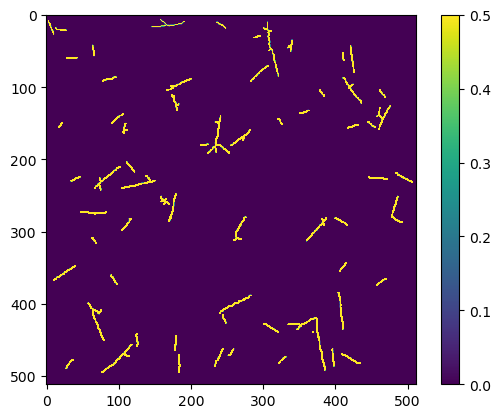

In [18]:
# Set scanning parameters
padding=3 #3
min_dist=9 #9
min_angle=20 #75

# Make a copy of the image
im_cleaned = im_relabel.copy()

#Define angles to test lines over
test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)

#Perform the transform for each labeled region
for n in np.unique(im_relabel)[1:]:
    x,y = np.where(im_relabel==n)
    mt_segment = im_relabel[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]

    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)
    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                            min_distance=min_dist,
                                            min_angle=min_angle,
                                            num_peaks=2)
    
    # If more than one line is fit to the region, eliminate the region from our image
    if len(angles)>=2:
        im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

#Plot
plt.imshow(im_cleaned, vmin=0, vmax=0.5)
plt.colorbar()

Extract properties of each region (i.e. major axis length, oreientation, etc.)

In [19]:
# Determine properties - we will need the centroid, major axis length etc
im_props = measure.regionprops_table(im_cleaned, 
                                     im_max, 
                                     properties = ['area', 
                                                    'major_axis_length', 
                                                    'minor_axis_length', 
                                                    'centroid', 
                                                    'orientation', 
                                                    'label'])
#Save as dataframe
df = pd.DataFrame(im_props)

#Show the dataframe
df

,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,label
0,54,50.351305,9.154060,14.240741,167.462963,-1.476690,1
1,19,23.702640,1.153974,18.000000,6.473684,0.392028,3
2,13,17.812950,1.323652,14.461538,242.000000,0.995881,4
3,85,88.791432,6.047401,45.823529,311.494118,0.224328,5
4,15,17.536800,1.793377,21.333333,20.000000,1.399206,10
...,...,...,...,...,...,...,...
60,24,27.849582,1.273979,474.500000,396.916667,0.107637,137
61,26,34.248105,2.050213,476.576923,421.500000,1.066434,138
62,25,28.860252,1.881551,483.000000,183.960000,0.033206,139
63,10,15.826816,0.742888,477.600000,326.500000,-0.811336,141


Exclude any microtubules with less than 3 pixels

In [20]:
df = df[df['area']>3]
df=df.reset_index()

## Determine a MT Track
Find the pixels that fall on the line of the MT track.

In [21]:
# Define a function
def mt_track(xc, yc, l, theta):
    # Ensure that theta is not greater than pi
    if theta >= np.pi:
        theta = theta - np.pi
  
  # If the track is more horizontal, find the x values for pixels falling along 
  #the line, then determine the corresponding y values
    if np.abs(theta) <= np.pi/4 or np.abs(theta)>3*np.pi/4:
        xvals = np.arange(xc-np.abs(0.5*l*np.cos(theta)), xc + np.abs(0.5*l*np.cos(theta)))
        yvals = ( np.tan(theta)*xvals ) + ( yc - np.tan(theta)*xc )
        
  # If the track is more vertical, find the y values for pixels falling along 
  # the line, then determine the x values
    else:
        yvals = np.arange(yc - np.abs(0.5*l*np.sin(theta)), yc + np.abs(0.5*l*np.sin(theta)))
        xvals = (yvals/np.tan(theta) + (xc - yc/np.tan(theta)))
  
  # Return the x and y values
    return xvals, yvals

${\color{red}{\text{Non-Essential - Just plotting:}}}$ Visualize the line overlapping with the MT track

# Kymo Fitting with skeleton in pipeline
Define functions to threshold the kymograph, and fit based on the centroid and skeleton methods. The centroids seem to fit the tracks the best in terms of looking like they produce the more accuratte speed line in the center of the kymograph. Using the skeleton can help rule out kymographs that split. For example when there are two MT in the feild of veiw.

In [22]:
def kymothresh(kymo, sigma):
  # Create a gaussian blur
    gauss = sf.gaussian(kymo, sigma = sigma)
    kymo_thresh = gauss
  #Threshold
    # kymo_otsu = sf.threshold_otsu(gauss)
    # kymo_thresh = gauss>kymo_otsu
    
    return kymo_thresh

def skeletonfit(kymo_thresh, pixel_size):
    kymo_otsu = sf.threshold_otsu(kymo_thresh)
    kymo_thresh = kymo_thresh>kymo_otsu
    kymo_thin = morphology.thin(kymo_thresh)
    xvals = np.where(kymo_thin)[1]
    yvals = np.where(kymo_thin)[0]
    # points of the skeleton to lines
    mfit_inv, bfit_inv = np.polyfit(yvals, xvals, deg=1)
    mfit = 1/mfit_inv
    bfit = - bfit_inv/mfit_inv

    #Calculate the speed (nm/s)
    speed = 1000*pixel_size/np.abs(mfit)

    #calculate the r^2 value of the fit
    ss_res =  np.sum((yvals - (mfit*xvals+bfit))**2)
    ss_tot = np.sum((yvals - np.average(yvals))**2)
    rsqrd = 1-(ss_res/ss_tot)

    return xvals, yvals, [mfit, bfit], speed, rsqrd

def centroidfit(kymo_thresh, pixel_size):
    kymo_otsu = sf.threshold_otsu(kymo_thresh)
    kymo_thresh = kymo_thresh>kymo_otsu
    
    #Find the center of mass of each row
    xvals = []
    for t, row_vals in enumerate(kymo_thresh):
        xindex = np.arange(len(row_vals))
        com = np.sum(row_vals*xindex)/np.sum(row_vals)
        xvals.append(com)
    xvals = np.array(xvals)

    #Find if there are nans - each time step is 1 second so it is just the index, would otherwise have to multiply by delta t
    yvals = np.where(~np.isnan(xvals))[0]
    xvals = xvals[np.where(~np.isnan(xvals))[0]]

    #Fit a line
    mfit_inv, bfit_inv = np.polyfit(yvals, xvals, deg=1)
    mfit = 1/mfit_inv
    bfit = - bfit_inv/mfit_inv
    #Calculate the speed (nm/s)
    speed = 1000*pixel_size/np.abs(mfit)

    #calculate the r^2 value of the fit
    ss_res =  np.sum((yvals - (mfit*xvals+bfit))**2)
    ss_tot = np.sum((yvals - np.average(yvals))**2)
    rsqrd = 1-(ss_res/ss_tot)

    return xvals, yvals, [mfit, bfit], speed, rsqrd 

Define a function that looks at both methods and reports the respective r^2 values and the speed from te centroid

In [23]:
def kymo_func(kymo, sigma, pixel_size, plot_returns = False):
    """
  params: kymo: image
          sigma: for the gaussian blur
          pixel_size: convert pixels to um
          method: 
          plot: (boolean) if you want to print the plot

  returns: speed
           rsqrd: r-squared squared value of the fit to the kymograph
           [mfit, bfit]: list of fit parameters
           frames: time values
           row_coms[frames]: center of mass of the MT at each time value

    """
    #Threshold the kymograph
    kymo_thresh = kymothresh(kymo, sigma)
    
    #Fit the kymographs based on centroid method, seems like the more accurate speed detector
    centroid_xvals, centroid_yvals, centroid_params, centroid_speed, centroid_rsqrd = centroidfit(kymo_thresh, pixel_size)

    #Fit the kymographs based on the skeleton method (here we really want to save the r^2 and get rid of anything negative good at picking up "Y"s)
    skele_xvals, skele_yvals, skele_params, skele_speed, skele_rsqrd = skeletonfit(kymo_thresh, pixel_size)
    
    if plot_returns == True:
        return centroid_speed, centroid_rsqrd, skele_rsqrd, centroid_xvals, centroid_yvals, centroid_params
    else:
        return centroid_speed, centroid_rsqrd, skele_rsqrd

${\color{red}{\text{Non-Essential - Just plotting:}}}$ Plot all the kymographs with the centroid fit

Save the r^2 values for the centroid and skeleton methods of kymograph analysis. Additionally save the number of centroids in each kymograph

In [ ]:
#Create empty lists for the speeds, r-squared values, and the number of centroids for each kymograph
speeds=[]
r2 = []
skeler2 = []

#Iterate through each MT track
for i in range(len(df)):

    # Define the line fitting the track
    xc =  df.loc[i, 'centroid-1']
    yc =  df.loc[i, 'centroid-0']
    l =  df.loc[i, 'major_axis_length']
    theta = -df.loc[i, 'orientation'] + (np.pi/2)
    
    xtrack, ytrack = mt_track(xc, yc, l, theta)
    
    #Ensure there is more than one point saved in the track line
    if len(xtrack)>1:

      # Create a kymograph
        mykymo = []

        for im in im_stack[start:stop]:
            ls=[]
            for i in range(len(xtrack)):
                if int(ytrack[i])<512 and int(xtrack[i])<512:
                    ls.append(im[int(ytrack[i]), int(xtrack[i])])
            mykymo.append(ls)
        mykymo = np.array(mykymo)

        # Compute the fit to the kymograph
        speed, centroid_rsqrd, skele_rsqrd = kymo_func(mykymo, sigma = 2, pixel_size = 0.161)
        
        #Append the fit results to the empty lists
        speeds.append(speed)
        r2.append(centroid_rsqrd)
        skeler2.append(skele_rsqrd)
    
    #if there is fewer than two centroids detected in the kymograph drop the track
    else:
        df=df.drop([i])

# Include the new columns in the DataFrame
speeds = np.array(speeds)
r2 = np.array(r2)
skeler2 = np.array(skeler2)
df['speed (nm/s)'] = speeds
df['r^2'] = r2
df['skele r^2'] = skeler2

Take the "good tracks" to be those with a positive r^2 for skeletonized kymographs and greater than 0.8 for centroid fits. 

In [25]:
df_good = df[df['r^2']>0.8][df['skele r^2']>0]

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_44371/512643897.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_good = df[df['r^2']>0.8][df['skele r^2']>0]


In [26]:
df_good

,index,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,label,speed (nm/s),r^2,skele r^2
1,1,19,23.702640,1.153974,18.000000,6.473684,0.392028,3,30.213716,0.885342,0.830711
5,5,10,11.912324,1.066090,30.900000,291.500000,-1.302341,15,17.710000,0.853147,0.778529
6,6,21,16.699408,5.623532,43.809524,338.285714,-0.229396,16,70.104902,0.934717,0.952397
7,7,15,17.557249,1.439404,50.000000,65.266667,0.177917,20,48.833929,0.950333,0.952160
10,10,15,17.290947,1.240451,60.133333,35.000000,1.538498,25,26.795966,0.969529,0.863340
11,11,25,38.769678,1.480552,80.600000,295.000000,-0.838372,26,38.856471,0.966165,0.895650
14,14,39,43.106735,3.674825,97.205128,182.282051,-1.120018,32,45.901709,0.907194,0.928250
18,18,51,35.986891,15.976222,140.843137,464.941176,-0.328630,39,47.229244,0.892268,0.489734
27,27,32,37.723684,4.400129,171.250000,269.812500,-0.918190,56,59.243956,0.876596,0.910304
35,35,38,44.910933,2.042435,267.500000,174.921053,-0.216632,78,85.278019,0.972550,0.815261


### Histogram

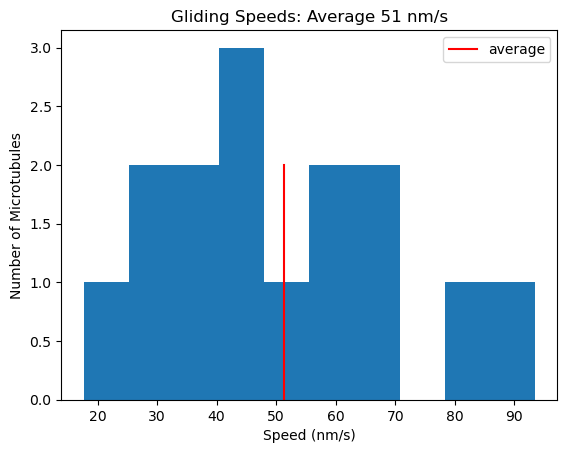

In [24]:
#plot a histogram
plt.hist(df_good['speed (nm/s)'])

#put a line at the average speed
avgspeed = np.average(df_good['speed (nm/s)'])
plt.plot([avgspeed, avgspeed], [0,2], color='r', label = 'average')

#Axis labels
plt.title('Gliding Speeds: Average ' + str(round(np.average(df_good['speed (nm/s)']))) + ' nm/s')
plt.xlabel('Speed (nm/s)')
plt.ylabel('Number of Microtubules')
plt.legend()

${\color{red}{\text{Non-Essential - Just plotting:}}}$ Plot all the "good" kymographs with the centroid fit. The next cell plots the first and last frames, the max projection with the fit line, and the kymograph

${\color{red}{\text{Non-Essential - Just plotting:}}}$ Show the skeletons of the kymographs. Plot all the all the raw kymographs, the gaussian blurred kymograph, and the skeleton fit on the otsu-thresh kymograph

# Determine MT length

Take the crop of each track and for individual time images, segment MT.

In [25]:
def cropped_MT_isolate(im):
    norm = (im - im.min())/(im.max()-im.min())
    im_niblack = filters.threshold_niblack(norm, window_size= 3, k=0.001)
    im_otsu = filters.threshold_otsu(im_niblack)
    
    #Make a binary image where values above the threshold are = 1 and all else is 0
    im_thresh = (im_niblack > im_otsu)
    
    #make a image with each patch labeled a unique number
    MT_label, num_label = measure.label(im_thresh, return_num=True)
    
    # Determine properties - we will need the centroid, major axis length etc
    MT_props = measure.regionprops_table(MT_label, im, properties = ['area', 
                                                    'major_axis_length', 
                                                    'minor_axis_length', 
                                                    'centroid', 
                                                    'orientation', 
                                                    'label'])

    return MT_label, MT_props

Equation to check if points fall within the ellipse created for each microtubule

In [26]:
def inellipse(x, y, x0, y0, major_l, minor_l, orient):
    major_len = 0.5*major_l
    minor_len=0.5*minor_l
    orientation = -orient+np.pi/2
    checkvals = (((x-x0)*np.cos(orientation) + (y-y0)*np.sin(orientation))**2 / major_len**2) + (((x-x0)*np.sin(orientation) - (y-y0)*np.cos(orientation))**2 / minor_len**2)
    return checkvals<=1

Make a new indexed dataframe to call from

In [27]:
df_newind=df_good.reset_index()

For each microtubule track, isolate microtubules in each image (each timepoint). Take the major axis length to be the length of the microtubule. Ensure that you pick the right microtubule by makeing sure that points in the track line fall within the ellipse.

In [28]:
#Store each MT length
MT_lengths=[]

#iterate through tracks
for index in df_newind['level_0']:
    #define track parameters
    xc =  df_good.loc[index, 'centroid-1']
    yc =  df_good.loc[index, 'centroid-0']
    lmajor =  df_good.loc[index, 'major_axis_length']
    lminor =  df_good.loc[index, 'minor_axis_length']
    theta = -df_good.loc[index, 'orientation'] + (np.pi/2)
    
    #Find the track axis lengths
    xmajor, ymajor = mt_track(xc, yc, lmajor, theta)
    xminor, yminor = mt_track(xc, yc, lminor, theta-np.pi/2)
    
    #define a crop window
    crop_win = int(lmajor/2+1)
    crop = np.s_[int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)]
    if int(xc-crop_win)<0:
        crop = np.s_[int(yc-crop_win) : int(yc+crop_win+1), 0 : int(xc+crop_win+1)]
    if int(yc-crop_win)<0:
        crop = np.s_[0 : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)]
    
    #Define the axis in the cropped reference frame
    cropmajx = xmajor-xc + crop_win 
    cropmajy = ymajor-yc + crop_win 

    #Find the length of the microtuble
    lengths = []
    
    #Create an ellipse fit for each MT region
    for j, im in enumerate(im_stack[start:stop]):
        im_label, im_props = cropped_MT_isolate(im[crop])
        for labi in np.unique(im_label)[:-1]:
            #Determine if the track line is in the MT ellipse
            inellip = inellipse(cropmajx, 
                                cropmajy, 
                                im_props['centroid-1'][labi], 
                                im_props['centroid-0'][labi], 
                                im_props['major_axis_length'][labi], 
                                im_props['minor_axis_length'][labi], 
                                im_props['orientation'][labi])
            #If MT track is in the ellipse, add the major axis length to the array
            if np.sum(inellip)>1:
                lengths.append(im_props['major_axis_length'][labi])
                
    #average the lengths and convert the to ums
    MT_lengths.append(np.average(lengths)*umperpixel)

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_35059/1521694600.py:5: RuntimeWarning: divide by zero encountered in true_divide
  checkvals = (((x-x0)*np.cos(orientation) + (y-y0)*np.sin(orientation))**2 / major_len**2) + (((x-x0)*np.sin(orientation) - (y-y0)*np.cos(orientation))**2 / minor_len**2)
/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Add lengths to df_good

In [29]:
df_good['MT len (um)'] = MT_lengths

Look at speed vs length

Text(0, 0.5, 'Speed (nm/s)')

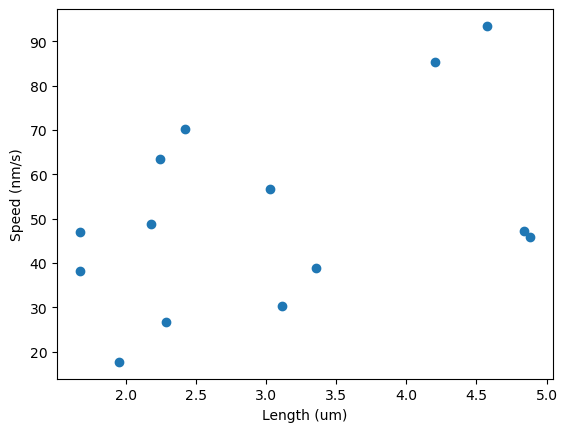

In [30]:
plt.scatter(df_good['MT len (um)'], df_good['speed (nm/s)'])
plt.xlabel('Length (um)')
plt.ylabel('Speed (nm/s)')

In [31]:
df_good

,index,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,label,speed (nm/s),r^2,skele r^2,MT len (um)
1,1,19,23.702640,1.153974,18.000000,6.473684,0.392028,3,30.213716,0.885342,0.830711,3.113325
5,5,10,11.912324,1.066090,30.900000,291.500000,-1.302341,15,17.710000,0.853147,0.778529,1.950305
6,6,21,16.699408,5.623532,43.809524,338.285714,-0.229396,16,70.104902,0.934717,0.952397,2.421370
7,7,15,17.557249,1.439404,50.000000,65.266667,0.177917,20,48.833929,0.950333,0.952160,2.181500
10,10,15,17.290947,1.240451,60.133333,35.000000,1.538498,25,26.795966,0.969529,0.863340,2.288608
11,11,25,38.769678,1.480552,80.600000,295.000000,-0.838372,26,38.856471,0.966165,0.895650,3.356687
14,14,39,43.106735,3.674825,97.205128,182.282051,-1.120018,32,45.901709,0.907194,0.928250,4.885362
18,18,51,35.986891,15.976222,140.843137,464.941176,-0.328630,39,47.229244,0.892268,0.489734,4.836187
27,27,32,37.723684,4.400129,171.250000,269.812500,-0.918190,56,59.243956,0.876596,0.910304,NaN
35,35,38,44.910933,2.042435,267.500000,174.921053,-0.216632,78,85.278019,0.972550,0.815261,4.206101


# Create columns for the concentrations

In [31]:
zeros = np.zeros(len(df_good))

df_good['motor conc'] = zeros + data_mot
df_good['MT dilute'] = zeros + data_MT
df_good['ATP'] = zeros + data_ATP
df_good['ADP'] = zeros + data_ADP
df_good['P'] = zeros + data_P
df_good['time (seconds)'] = zeros + data_time

In [32]:
df_good

,index,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,label,speed (nm/s),r^2,skele r^2,MT len (um),motor conc,MT dilute,ATP,ADP,P,time (seconds)
1,1,19,23.702640,1.153974,18.000000,6.473684,0.392028,3,30.213716,0.885342,0.830711,3.113325,0.0625,50.0,1410.0,0.0,0.0,900.0
5,5,10,11.912324,1.066090,30.900000,291.500000,-1.302341,15,17.710000,0.853147,0.778529,1.950305,0.0625,50.0,1410.0,0.0,0.0,900.0
6,6,21,16.699408,5.623532,43.809524,338.285714,-0.229396,16,70.104902,0.934717,0.952397,2.421370,0.0625,50.0,1410.0,0.0,0.0,900.0
7,7,15,17.557249,1.439404,50.000000,65.266667,0.177917,20,48.833929,0.950333,0.952160,2.181500,0.0625,50.0,1410.0,0.0,0.0,900.0
10,10,15,17.290947,1.240451,60.133333,35.000000,1.538498,25,26.795966,0.969529,0.863340,2.288608,0.0625,50.0,1410.0,0.0,0.0,900.0
11,11,25,38.769678,1.480552,80.600000,295.000000,-0.838372,26,38.856471,0.966165,0.895650,3.356687,0.0625,50.0,1410.0,0.0,0.0,900.0
14,14,39,43.106735,3.674825,97.205128,182.282051,-1.120018,32,45.901709,0.907194,0.928250,4.885362,0.0625,50.0,1410.0,0.0,0.0,900.0
18,18,51,35.986891,15.976222,140.843137,464.941176,-0.328630,39,47.229244,0.892268,0.489734,4.836187,0.0625,50.0,1410.0,0.0,0.0,900.0
27,27,32,37.723684,4.400129,171.250000,269.812500,-0.918190,56,59.243956,0.876596,0.910304,NaN,0.0625,50.0,1410.0,0.0,0.0,900.0
35,35,38,44.910933,2.042435,267.500000,174.921053,-0.216632,78,85.278019,0.972550,0.815261,4.206101,0.0625,50.0,1410.0,0.0,0.0,900.0


# Save CSV

In [33]:
#Save df_good
df_good.to_csv('../../analyzed_data/gliding/'+ file_folder.split('/')[0] +'/' + file_folder.split('/')[1] + '-start' + str(start) + '_stop' + str(stop) + '.csv', sep=',')

### scratch work on MT length

In [34]:
labi = 0
inellip = inellipse(cropmajx, cropmajy, im_props['centroid-1'][labi], im_props['centroid-0'][labi], im_props['major_axis_length'][labi], im_props['minor_axis_length'][labi], im_props['orientation'][labi])

In [35]:
inxval = []
inyval = []
for i in np.arange(np.shape(im_label)[0]):   
    for j in np.arange(np.shape(im_label)[1]):
        if inellipse(j, i, im_props['centroid-1'][labi], im_props['centroid-0'][labi], im_props['major_axis_length'][labi], im_props['minor_axis_length'][labi], im_props['orientation'][labi]):
            inyval.append(i)
            inxval.append(j)
                       

In [36]:
cropmajx-im_props['centroid-0'][0]

array([-3.97392149, -2.97392149, -1.97392149, -0.97392149,  0.02607851,
        1.02607851,  2.02607851,  3.02607851,  4.02607851,  5.02607851,
        6.02607851,  7.02607851,  8.02607851,  9.02607851, 10.02607851,
       11.02607851, 12.02607851, 13.02607851, 14.02607851, 15.02607851,
       16.02607851, 17.02607851, 18.02607851, 19.02607851, 20.02607851,
       21.02607851, 22.02607851, 23.02607851])

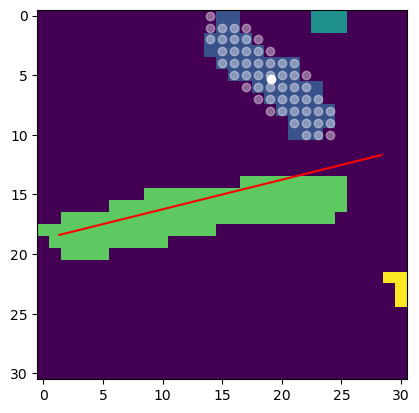

In [37]:
fig, ax = plt.subplots()
plt.imshow(im_label)
for i, truth in enumerate(inellip):
    if truth==True:
        plt.scatter(cropmajx[i], cropmajy[i], color='w')
# ellip = mpl.patches.Ellipse((im_props['centroid-1'][labi], im_props['centroid-0'][labi]), im_props['major_axis_length'][labi], im_props['minor_axis_length'][labi], angle=(im_props['orientation'][labi])*360, fill=False, ec='w')
# ax.add_patch(ellip)
plt.scatter(im_props['centroid-1'][labi], im_props['centroid-0'][labi], color='w')

plt.scatter(inxval, inyval, color='w', alpha=0.4)
plt.plot(cropmajx, cropmajy, color='r')

In [38]:
MT_lengths = []
for i, index in enumerate(df_good.index):
    print(index)
    xc =  df_good.loc[index, 'centroid-1']
    yc =  df_good.loc[index, 'centroid-0']
    lmajor =  df_good.loc[index, 'major_axis_length']
    lminor =  df_good.loc[index, 'minor_axis_length']
    theta = -df_good.loc[index, 'orientation'] + (np.pi/2)

    xmajor, ymajor = mt_track(xc, yc, lmajor, theta)
    xminor, yminor = mt_track(xc, yc, lminor, theta-np.pi/2)

    crop_win = int(lmajor/2+1)
    crop = np.s_[int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)]

    lengths = []
    for j, im in enumerate(im_stack[start:stop]):
        length = cropped_MT_isolate(im[crop])['major_axis_length']
        if len(length)==1:
            lengths.append(length[0])
    print(lengths)
    MT_lengths.append(np.average(lengths))
    

0


TypeError: tuple indices must be integers or slices, not str

In [ ]:
cropped_MT_isolate(im_stack[30][crop])['major_axis_length'][0]

In [ ]:
plt.imshow(im_stack[5][crop])

In [ ]:
for i, index in enumerate(df_good.index):
    xc =  df_good.loc[index, 'centroid-1']
    yc =  df_good.loc[index, 'centroid-0']
    lmajor =  df_good.loc[index, 'major_axis_length']
    lminor =  df_good.loc[index, 'minor_axis_length']
    theta = -df_good.loc[index, 'orientation'] + (np.pi/2)

    xmajor, ymajor = mt_track(xc, yc, lmajor, theta)
    xminor, yminor = mt_track(xc, yc, lminor, theta-np.pi/2)

    crop_win = int(lmajor/2+1)
    crop = np.s_[int(yc-crop_win) : int(yc+crop_win+1), int(xc-crop_win) : int(xc+crop_win+1)]
    
    cropmajx = xmajor-xc + crop_win 
    cropmajy = ymajor-yc + crop_win 
    
    for j, im in enumerate()
    
    
    
    
    
    
    ax[i][0].imshow(im_stack[start][crop])
    ax[i][1].imshow(im_cleaned[crop])
    ax[i][2].imshow(im_stack[stop-1][crop])
    
    ax[i][0].plot(cropmajx, cropmajy, color='r')
    ax[i][1].plot(cropmajx, cropmajy, color='r')
    ax[i][2].plot(cropmajx, cropmajy, color='r')
    
    ax[i][0].set_ylabel('i=' + str(index) + ' v=' + str(round(df_good.loc[index, 'speed (nm/s)'])))

    mykymo = []
    for im in im_stack[start:stop]:
        ls=[]
        for j in range(len(xmajor)):
            ls.append(im[int(ymajor[j]), int(xmajor[j])])
        mykymo.append(ls)
    mykymo = np.array(mykymo)
    
    speed, centroid_rsqrd, skele_rsqrd, centroid_xvals, centroid_yvals, lineparams = kymo_func(mykymo, sigma = 2, pixel_size = 0.161, plot_returns = True)
    
    ax[i][3].imshow(mykymo)
    ax[i][3].scatter(centroid_xvals, centroid_yvals, color='k')
    xdex = np.arange(len(mykymo[0]))
    ax[i][3].plot(centroid_xvals, lineparams[0]*centroid_xvals+lineparams[1], color='r')
    ax[i][3].set_ylim(0, len(mykymo)-1)

ax[0][0].set_title('First Frame')
ax[0][1].set_title('Maximum Projection')
ax[0][2].set_title('Last Frame')
ax[0][3].set_title('Kymograph')

Test

In [ ]:
from skimage.draw import ellipse
from skimage.transform import rotate
import math

image = np.zeros((600, 600))

rr, cc = ellipse(300, 350, 100, 220)
image[rr, cc] = 1

image = rotate(image, angle=15, order=0)

rr, cc = ellipse(100, 100, 60, 50)
image[rr, cc] = 1

label_img = measure.label(image)
regions = measure.regionprops(label_img)

In [ ]:
regions[0]

In [ ]:
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length
    
    inxval = []
    inyval = []
    for i in np.arange(np.shape(image)[0]):   
        for j in np.arange(np.shape(image)[1]):
            if inellipse(i, j, y0, x0, 0.5*props.major_axis_length, 0.5*props.minor_axis_length, orientation):
                inyval.append(i)
                inxval.append(j)
    ax.scatter(inxval, inyval, color='b', alpha=0.2, s=0.1)
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    # minr, minc, maxr, maxc = props.bbox
    # bx = (minc, maxc, maxc, minc, minc)
    # by = (minr, minr, maxr, maxr, minr)
    # ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()


# Movie

In [ ]:
#Movie
import celluloid as cell
import matplotlib.animation as animation

Save each track as its own movie

Save the "good" tracks in the same movie

In [ ]:
fig,ax = plt.subplots()
camera = cell.Camera(fig)
for index in tqdm(df_good.index):
    xc =  df_good.loc[index, 'centroid-1']
    yc =  df_good.loc[index, 'centroid-0']
    lmajor =  df_good.loc[index, 'major_axis_length']
    theta = -df_good.loc[index, 'orientation'] + (np.pi/2)

    crop_width = int(lmajor/2+1)
    crop_win = np.s_[int(yc-crop_width) : int(yc+crop_width+1), int(xc-crop_width) : int(xc+crop_width+1)]
    if int(xc-crop_width)<0:
        crop_win = np.s_[int(yc-crop_width) : int(yc+crop_width+1), 0 : int(xc+crop_width+1)]
    if int(yc-crop_width)<0:
        crop_win = np.s_[0 : int(yc+crop_width+1), int(xc-crop_width) : int(xc+crop_width+1)]
    
    xmajor, ymajor = mt_track(xc, yc, lmajor, theta)
    cropmajx = xmajor-xc + crop_width 
    cropmajy = ymajor-yc + crop_width

    for i, im in enumerate(im_stack[start:stop]):
        im_temp = im[crop_win]
        ax.imshow(im_temp, vmin=100, vmax=500, animated = True)
        ax.plot(cropmajx, cropmajy, color='w')
        ax.text(0,3, s='Track ' + str(index), color='w', fontsize = 'x-large')
        ax.axis('off')
        camera.snap()

animation = camera.animate()
animation.save("../../analyzed_data/gliding/" + file_folder.split('/')[0] + "/Good_MT_Track-" + file_folder.split('/')[1] + '-start'+str(start) + '_stop'+str(stop) + ".mp4", fps = 50)

Save ALL the tracks in the same movie